To cluster students based on their patterns in studying

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  # or .sum() if you prefer total score
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# 3.1 Merge total_assessments (on code_module + code_presentation)
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# 3.2 Merge attempted_assessments & average_score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# 3.3 Merge total_vle_clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Replace NaN with 0 if needed
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"] = df_merged["total_assessments"].fillna(0)
df_merged["score"] = df_merged["score"].fillna(0)  # if missing, assume 0 or handle differently
df_merged["total_vle_clicks"] = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment_completion_ratio safely
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# Filter out withdrawn
df_merged = df_merged[
    (df_merged["final_result"] != "Withdrawn") 
].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# ---------------------------
# Final DataFrame including module
# ---------------------------
df_final = df_merged[
    [
        "id_student",
        "code_module",            # <-- include the module feature here
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

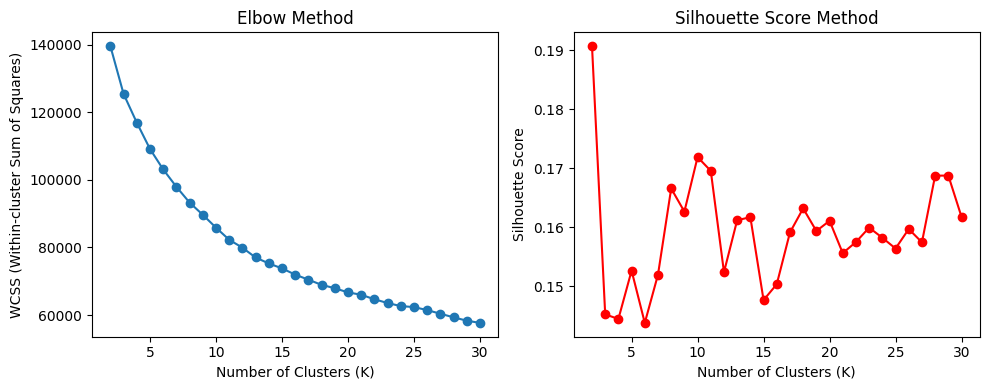

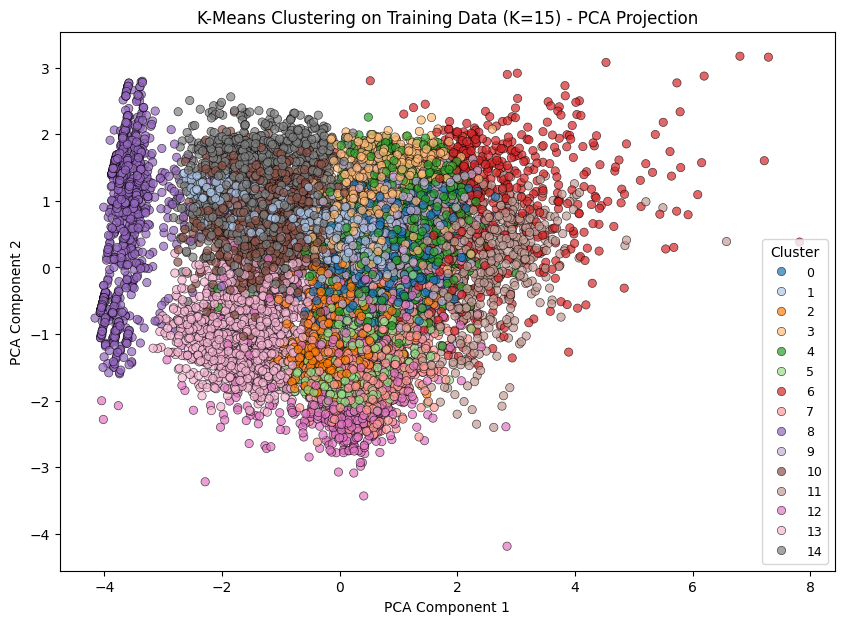

         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           3.576258  78.753007  0.972484  8.886792  0.180031   0.000000   
1           5.904949  78.162416  0.000000  5.718775  1.318146   0.406127   
2           1.413223  74.467326  0.080283  5.940968  2.085006   0.025974   
3           4.215432  77.823535  0.951108  5.759358  2.103896   0.043545   
4           3.412565  79.145708  0.994171  5.727332  0.993523   1.059585   
5           1.722798  76.211997  0.004318  6.064767  0.168394   0.000000   
6           3.878092  84.041148  0.680212  5.690813  1.104240   0.659011   
7           1.457576  77.471205  0.000758  5.878788  0.838636   1.006818   
8           3.394924   1.626182  0.541117  6.116751  1.316751   0.280203   
9           3.941385  79.068781  0.941385  2.353464  0.193606   0.000888   
10          3.696686  65.268244  0.943925  6.101954  0.149533   0.153781   
11          

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ===========================
# Data Preprocessing and Train-Test Split
# ===========================

# Load your processed dataframe (df_final) and make a copy
df = df_final.copy()

# Split into training and test sets right away (e.g., 70% train, 30% test)
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Drop student ID (not relevant for clustering)
train_df = train_df.drop(columns=['id_student'])
test_df = test_df.drop(columns=['id_student'])

# ===========================
# Encode Categorical Variables
# ===========================

# List of categorical columns to encode
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {}

# Fit label encoders on training set and transform both train and test sets
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# ===========================
# Standardize Features for Clustering
# ===========================

# Fit the scaler on training data and transform both sets
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

# ===========================
# Finding Optimal K using Elbow & Silhouette Methods (Training Set Only)
# ===========================

wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 30
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(train_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(train_scaled, cluster_labels))

# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

plt.tight_layout()
plt.show()

# ===========================
# Applying K-Means with Optimal K on Training Data
# ===========================

optimal_k = 15  # Change this based on the analysis from the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_df['Cluster'] = kmeans.fit_predict(train_scaled)

# ===========================
# Assign Clusters to Test Set
# ===========================

# KMeans has a built-in predict method for new data
test_df['Cluster'] = kmeans.predict(test_scaled)

# ===========================
# Visualizing Clusters using PCA (2D Projection)
# ===========================

# Fit PCA on training scaled data
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
train_df['PCA1'] = train_pca[:, 0]
train_df['PCA2'] = train_pca[:, 1]

# Transform test set using the same PCA model
test_pca = pca.transform(test_scaled)
test_df['PCA1'] = test_pca[:, 0]
test_df['PCA2'] = test_pca[:, 1]

# Visualize the training set clusters using PCA projection
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=train_df['PCA1'], y=train_df['PCA2'],
    hue=train_df['Cluster'], palette="tab20",
    alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering on Training Data (K={optimal_k}) - PCA Projection")

# Adjust legend for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)
plt.show()

# ===========================
# Display Cluster Statistics (Training Set)
# ===========================

print(train_df.groupby('Cluster').mean())


Calculate optimal eps

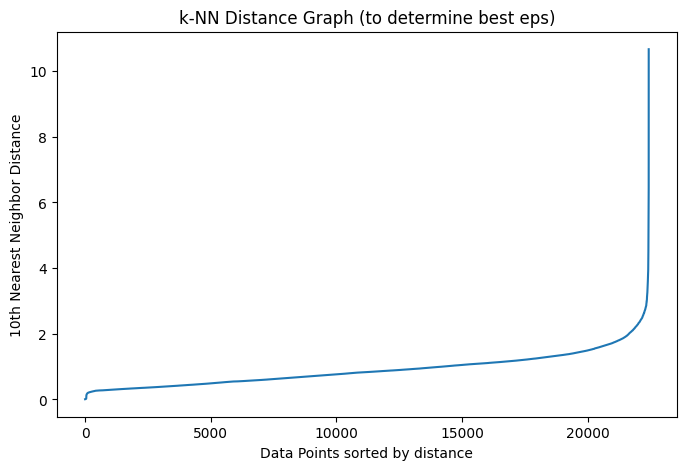

In [9]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit NearestNeighbors model
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Sort and plot k-distance graph
distances = np.sort(distances[:, 9], axis=0)  # 10th neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("k-NN Distance Graph (to determine best eps)")
plt.show()


### DBScan

PCA Loadings:
      id_student  code_module     score    Gender    Region       HLE  \
PCA1    0.049308     0.068848  0.484551  0.111114 -0.026110 -0.110449   
PCA2   -0.073575     0.678820 -0.117210  0.581273 -0.086457  0.196992   

      Age group  Credit Distribution  assessment_completion_ratio  \
PCA1   0.100251             0.002529                     0.513911   
PCA2  -0.070621            -0.218291                    -0.060670   

      total_vle_clicks    target  
PCA1          0.444916  0.510588  
PCA2          0.219702 -0.176932  
Number of Clusters found by DBSCAN on Training Set: 12


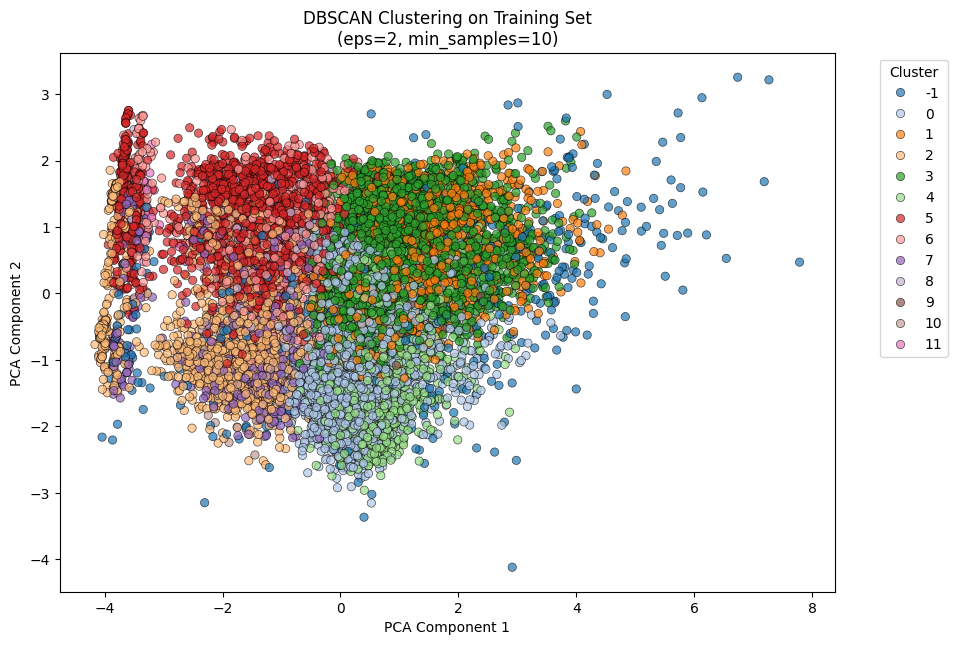

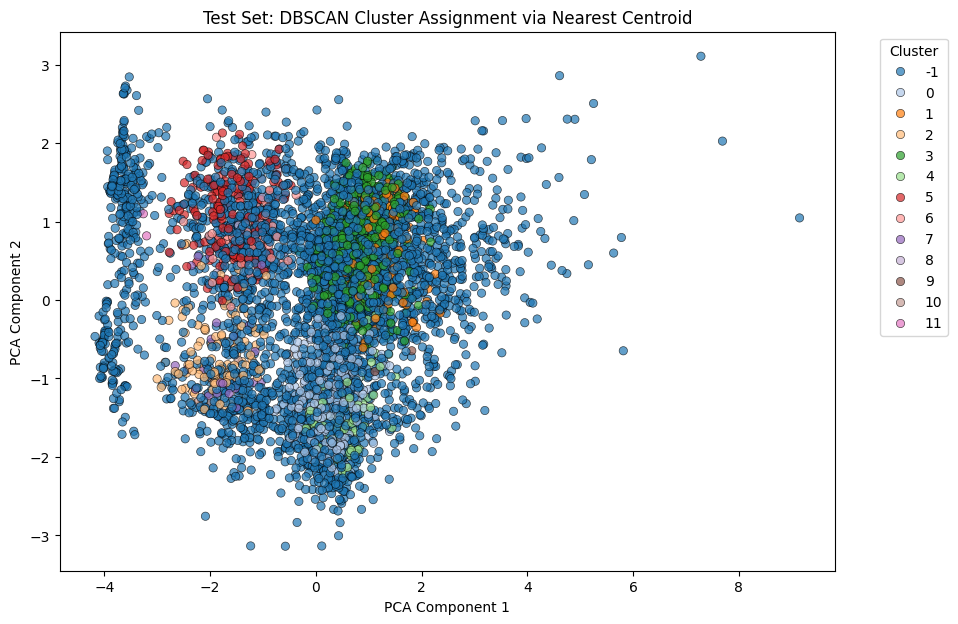

Number of noise points (outliers) in Training Set: 520
Number of noise points (outliers) in Test Set: 3823


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin_min

# ===========================
# Data Preprocessing & Train-Test Split
# ===========================

# Assume df is your DataFrame. If a 'Cluster' column exists from prior processing, drop it.
df_features = df.drop(columns=['Cluster'], errors='ignore').copy()

# Split into training and test sets (e.g., 70% train, 30% test)
train_df, test_df = train_test_split(df_features, test_size=0.25, random_state=42)

# ===========================
# Encode Categorical Variables
# ===========================

# List of categorical columns to encode
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {}

# Fit label encoders on training set and transform both train and test sets
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# ===========================
# Standardize the Data (Training Only)
# ===========================

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

# (Optional) Get feature names for later use
feature_names = train_df.columns

# ===========================
# PCA for Visualization & Loadings (Training Set)
# ===========================

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)

# Create a DataFrame for PCA loadings (component coefficients)
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=['PCA1', 'PCA2'])
print("PCA Loadings:")
print(loadings)

# ===========================
# Apply DBSCAN on Training Data
# ===========================

# Tune parameters: eps (radius) and min_samples (minimum points per cluster)
dbscan = DBSCAN(eps=2, min_samples=10)
train_dbscan_labels = dbscan.fit_predict(train_scaled)
train_df = train_df.copy()  # Ensure we're not modifying a view
train_df['DBSCAN_Cluster'] = train_dbscan_labels

# Count the number of clusters found (ignoring noise: label -1)
num_clusters_train = len(set(train_dbscan_labels)) - (1 if -1 in train_dbscan_labels else 0)
print(f"Number of Clusters found by DBSCAN on Training Set: {num_clusters_train}")

# ===========================
# Assign DBSCAN Cluster Labels to Test Data
# ===========================

# Since DBSCAN has no predict method, compute centroids for each valid cluster (exclude noise)
valid_clusters = np.unique(train_dbscan_labels[train_dbscan_labels != -1])
centroids = {}
for cluster in valid_clusters:
    mask = (train_dbscan_labels == cluster)
    centroids[cluster] = train_scaled[mask].mean(axis=0)

# Convert centroids to an array and keep corresponding labels for assignment
if len(centroids) > 0:
    centroid_array = np.vstack(list(centroids.values()))
    cluster_labels = list(centroids.keys())
else:
    centroid_array = np.empty((0, train_scaled.shape[1]))
    cluster_labels = []

def assign_cluster(sample, centroid_array, cluster_labels, threshold=2):
    # If no centroids exist, assign noise
    if centroid_array.shape[0] == 0:
        return -1
    sample = sample.reshape(1, -1)
    closest, distances = pairwise_distances_argmin_min(sample, centroid_array)
    # Assign the nearest cluster if within threshold, else label as noise (-1)
    return cluster_labels[closest[0]] if distances[0] <= threshold else -1

# Apply the function to each test sample
test_dbscan_labels = np.array([assign_cluster(sample, centroid_array, cluster_labels, threshold=dbscan.eps)
                               for sample in test_scaled])
test_df = test_df.copy()
test_df['DBSCAN_Cluster'] = test_dbscan_labels

# ===========================
# Visualizing DBSCAN Clusters using PCA
# ===========================

# Transform test set using the same PCA (fitted on training data)
test_pca = pca.transform(test_scaled)
train_df['PCA1'] = train_pca[:, 0]
train_df['PCA2'] = train_pca[:, 1]
test_df['PCA1'] = test_pca[:, 0]
test_df['PCA2'] = test_pca[:, 1]

# Plot DBSCAN clusters for Training Set
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=train_df['PCA1'], y=train_df['PCA2'],
    hue=train_df['DBSCAN_Cluster'], palette="tab20",
    alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"DBSCAN Clustering on Training Set\n(eps={dbscan.eps}, min_samples={dbscan.min_samples})")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot DBSCAN cluster assignments for Test Set
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=test_df['PCA1'], y=test_df['PCA2'],
    hue=test_df['DBSCAN_Cluster'], palette="tab20",
    alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Test Set: DBSCAN Cluster Assignment via Nearest Centroid")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ===========================
# Summary Statistics: Count Noise Points
# ===========================

num_noise_train = np.sum(train_df['DBSCAN_Cluster'] == -1)
num_noise_test = np.sum(test_df['DBSCAN_Cluster'] == -1)
print(f"Number of noise points (outliers) in Training Set: {num_noise_train}")
print(f"Number of noise points (outliers) in Test Set: {num_noise_test}")


### Cluster Labelling stuff


In [6]:
# Assuming df_scaled is already defined and used elsewhere in your workflow.

# Create a new standardized DataFrame for eigen analysis with proper index alignment.
scaler = StandardScaler()
df_scaled_eig = pd.DataFrame(
    scaler.fit_transform(df.drop(columns=['Cluster'], errors='ignore')),
    columns=df.drop(columns=['Cluster'], errors='ignore').columns,
    index=df.index  # This ensures that the index aligns with df
)

# ---------------------------
# Eigen Analysis for Each Cluster using df_scaled_eig
# ---------------------------
print("\n--- Eigen Analysis for Each Cluster ---")
eigen_analysis_results = {}

# Loop through clusters (skip noise labeled as -1)
unique_clusters = df['DBSCAN_Cluster'].unique()
for cluster in unique_clusters:
    if cluster == -1:
        continue
    
    # Use the aligned standardized data for the current cluster
    cluster_data = df_scaled_eig[df['DBSCAN_Cluster'] == cluster]
    
    # Compute the covariance matrix (columns are features)
    cov_matrix = np.cov(cluster_data, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order (largest eigenvalue first)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    eigen_analysis_results[cluster] = {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors
    }
    
    # Print results for this cluster
    print(f"\nCluster {cluster}:")
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)



--- Eigen Analysis for Each Cluster ---

Cluster 0:
Eigenvalues:
[ 2.33580303e+00  1.04915503e+00  1.00996335e+00  9.21417039e-01
  4.96793208e-01  2.67883542e-01  1.68934924e-01  1.11671353e-15
  2.94446466e-17  1.10548620e-17  4.87891777e-32  0.00000000e+00
 -5.06702833e-17]
Eigenvectors:
[[-7.30471511e-01 -1.25779742e-01  1.06884553e-01 -1.60549793e-01
   4.25225231e-01  3.19414249e-02 -1.49532596e-02 -4.76289275e-01
   2.95436807e-02  3.32345262e-02 -4.22257004e-16  0.00000000e+00
  -2.67957628e-02]
 [-7.36179428e-02 -1.20870342e-01 -5.42073815e-02 -1.42248293e-02
   7.03663034e-04 -9.03561749e-01  2.75011086e-01  1.06436056e-01
   1.22956814e-01  1.13408269e-01 -8.77850185e-16  0.00000000e+00
  -2.40791023e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 9.24104571e-02 -6.44184807e-01  6.98503786e-01  2.857

In [ ]:
# ----- Cluster Profiling for Numeric Features -----
# Define the numeric columns you want to summarize.
numeric_cols = ['score', 'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks']

# Compute the mean and median for each numeric feature per cluster.
cluster_numeric_profiles = df.groupby('Cluster')[numeric_cols].agg(['mean', 'median'])
print("Numeric Cluster Profiles:")
print(cluster_numeric_profiles)

# ----- Cluster Profiling for Categorical Features -----
# Define the categorical columns (these are still in their original or label-encoded form).
categorical_cols = ['code_module', 'Gender', 'Region', 'HLE', 'Age group']

# For categorical features, we can use the mode (most common value) to summarize each cluster.
def mode_func(series):
    return series.mode().iloc[0]

cluster_categorical_profiles = df.groupby('Cluster')[categorical_cols].agg(mode_func)
print("\nCategorical Cluster Profiles:")
print(cluster_categorical_profiles)

# ----- Alternative: Detailed Summary for Each Cluster -----
# This loop prints a full descriptive summary for each cluster, including counts and other stats.
for cluster, group in df.groupby('Cluster'):
    print(f"\nCluster {cluster} Detailed Summary:")
    print(group.describe(include='all'))


Numeric Cluster Profiles:
             score            Credit Distribution         \
              mean     median                mean median   
Cluster                                                    
0        71.611210  73.000000          185.152625  180.0   
1        78.309177  79.500000           72.386414   60.0   
2        78.377456  80.250000           39.297337   30.0   
3         2.377624   0.000000           69.639476   60.0   
4        79.234490  80.500000           67.604749   60.0   
5        83.802928  85.857143           77.079262   60.0   
6        65.384961  66.000000           73.436313   60.0   
7        75.601520  77.090909           75.664639   60.0   
8        66.180800  67.666667           77.910995   60.0   
9        76.204110  78.222222           75.388746   60.0   

        assessment_completion_ratio           total_vle_clicks          
                               mean    median             mean  median  
Cluster                                        

Now we add the profile/cluster as a new feature to re run our algos

In [ ]:
# Add the DBSCAN cluster labels to the dataset
df_final['DBSCAN_Cluster'] = df['DBSCAN_Cluster']

# Convert cluster labels to categorical type (important for tree-based models)
df_final['DBSCAN_Cluster'] = df_final['DBSCAN_Cluster'].astype('category')

# Check new dataset with clusters
print(df_final.head())


   id_student code_module  score Gender                Region  \
0       11391         AAA   82.0      M   East Anglian Region   
1       28400         AAA   66.4      F              Scotland   
3       31604         AAA   76.0      F     South East Region   
4       32885         AAA   54.4      F  West Midlands Region   
5       38053         AAA   68.0      M                 Wales   

                     HLE Age group  Credit Distribution  \
0       HE Qualification      55<=                  240   
1       HE Qualification     35-55                   60   
3  A Level or Equivalent     35-55                   60   
4     Lower Than A Level      0-35                   60   
5  A Level or Equivalent     35-55                   60   

   assessment_completion_ratio  total_vle_clicks  target DBSCAN_Cluster  
0                     0.833333             934.0       1             -1  
1                     0.833333            1435.0       1              0  
3                     0.833333  

# Final Results with DBScan


## Preprocessing


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import clone

# ===========================
# 1) Preprocessing
# ===========================

# Ensure the DBSCAN_Cluster column is categorical in both train and test sets.
train_df['DBSCAN_Cluster'] = train_df['DBSCAN_Cluster'].astype('category')
test_df['DBSCAN_Cluster'] = test_df['DBSCAN_Cluster'].astype('category')

# Define features including DBSCAN cluster and module
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module', 'DBSCAN_Cluster'  # <-- Added DBSCAN cluster
]

# Extract training and test features and target
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

# One-Hot Encode Categorical Features for both training and test sets
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module', 'DBSCAN_Cluster']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns between training and test sets (fill missing columns with zeros)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Create sample weights based on module frequency (calculated from the training set)
module_counts = train_df['code_module'].value_counts()
train_df['module_weight'] = train_df['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = train_df['module_weight']

# Define Models using the Best Parameters
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_leaf=4,
        min_samples_split=2,
        class_weight='balanced',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        max_features=None,
        min_samples_leaf=4,
        min_samples_split=2,
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            class_weight='balanced',
            random_state=42
        ),
        n_estimators=200,
        learning_rate=0.01,
        random_state=42
    )
}

print("Preprocessing complete. Features and models are defined.")


KeyError: 'DBSCAN_Cluster'

## K-Fold Cross-Validation on training subset

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.base import clone

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Prepare a dictionary to store metrics for each model
cv_results = {model_name: {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'auc': []}
              for model_name in models.keys()}

# Perform cross-validation on the training data (X_train_encoded, y_train, sample_weights)
for fold, (train_index, val_index) in enumerate(skf.split(X_train_encoded, y_train), start=1):
    X_cv_train = X_train_encoded.iloc[train_index]
    X_cv_val   = X_train_encoded.iloc[val_index]
    y_cv_train = y_train.iloc[train_index]
    y_cv_val   = y_train.iloc[val_index]
    w_cv_train = sample_weights.iloc[train_index]
    w_cv_val   = sample_weights.iloc[val_index]
    
    print(f"\n===== Cross-Validation Fold {fold} =====")
    
    for model_name, model in models.items():
        # Clone the model so that each fold starts fresh
        clf = clone(model)
        clf.fit(X_cv_train, y_cv_train, sample_weight=w_cv_train)
        
        y_cv_pred = clf.predict(X_cv_val)
        # Get probabilities for AUC calculation if the classifier supports it
        y_cv_proba = clf.predict_proba(X_cv_val)[:, 1] if hasattr(clf, "predict_proba") else None
        
        # Compute metrics
        acc  = accuracy_score(y_cv_val, y_cv_pred)
        bal_acc = balanced_accuracy_score(y_cv_val, y_cv_pred)
        f1   = f1_score(y_cv_val, y_cv_pred)
        auc  = roc_auc_score(y_cv_val, y_cv_proba, sample_weight=w_cv_val) if y_cv_proba is not None else None
        
        cv_results[model_name]['accuracy'].append(acc)
        cv_results[model_name]['balanced_accuracy'].append(bal_acc)
        cv_results[model_name]['f1'].append(f1)
        if auc is not None:
            cv_results[model_name]['auc'].append(auc)
        
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if auc is not None:
            print(f"AUC: {auc:.4f}")
        
print("\n===== Cross-Validation Summary =====")
for model_name in models.keys():
    avg_acc = np.mean(cv_results[model_name]['accuracy'])
    avg_bal_acc = np.mean(cv_results[model_name]['balanced_accuracy'])
    avg_f1 = np.mean(cv_results[model_name]['f1'])
    avg_auc = np.mean(cv_results[model_name]['auc']) if cv_results[model_name]['auc'] else None
    
    print(f"\n{model_name} Averages (k={k} folds):")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Balanced Accuracy: {avg_bal_acc:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    if avg_auc is not None:
        print(f"AUC: {avg_auc:.4f}")



===== Cross-Validation Fold 1 =====

Model: Decision Tree
Accuracy: 0.9857
Balanced Accuracy: 0.9820
F1 Score: 0.9896
AUC: 0.9781

Model: Random Forest
Accuracy: 0.9911
Balanced Accuracy: 0.9859
F1 Score: 0.9935
AUC: 0.9792

Model: AdaBoost
Accuracy: 0.9685
Balanced Accuracy: 0.9557
F1 Score: 0.9773
AUC: 0.9963

===== Cross-Validation Fold 2 =====

Model: Decision Tree
Accuracy: 0.9851
Balanced Accuracy: 0.9800
F1 Score: 0.9892
AUC: 0.9771

Model: Random Forest
Accuracy: 0.9887
Balanced Accuracy: 0.9826
F1 Score: 0.9918
AUC: 0.9778

Model: AdaBoost
Accuracy: 0.9739
Balanced Accuracy: 0.9612
F1 Score: 0.9812
AUC: 0.9970

===== Cross-Validation Fold 3 =====

Model: Decision Tree
Accuracy: 0.9846
Balanced Accuracy: 0.9796
F1 Score: 0.9888
AUC: 0.9790

Model: Random Forest
Accuracy: 0.9881
Balanced Accuracy: 0.9822
F1 Score: 0.9914
AUC: 0.9799

Model: AdaBoost
Accuracy: 0.9673
Balanced Accuracy: 0.9518
F1 Score: 0.9765
AUC: 0.9924

===== Cross-Validation Fold 4 =====

Model: Decision Tree

## Perf on entire training dataset

In [ ]:
# 4) C: Training performance on the entire training subset
training_scores = {}

for model_name, model in models.items():
    # Clone the model so each training starts fresh
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_train_pred = clf.predict(X_train_encoded)
    y_train_proba = clf.predict_proba(X_train_encoded)[:, 1]
    
    acc_train = accuracy_score(y_train, y_train_pred)
    bal_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba, sample_weight=sample_weights)
    
    training_scores[model_name] = {
        'accuracy': acc_train,
        'balanced_accuracy': bal_acc_train,
        'f1': f1_train,
        'auc': auc_train
    }

print("\n===== Training Performance on Entire Training Subset =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {training_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {training_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {training_scores[model_name]['f1']:.4f}")
    print(f"AUC: {training_scores[model_name]['auc']:.4f}")



===== Training Performance on Entire Training Subset =====

Decision Tree:
Accuracy: 0.9866
Balanced Accuracy: 0.9827
F1 Score: 0.9903
AUC: 0.9839

Random Forest:
Accuracy: 0.9906
Balanced Accuracy: 0.9856
F1 Score: 0.9931
AUC: 0.9858

AdaBoost:
Accuracy: 0.9748
Balanced Accuracy: 0.9629
F1 Score: 0.9818
AUC: 0.9973


## Perf on holdout

In [ ]:
# 5) D: Validation (Holdout) Performance
validation_scores = {}

for model_name, model in models.items():
    # Refit each model on the entire training set
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    
    y_val_pred = clf.predict(X_test_encoded)
    y_val_proba = clf.predict_proba(X_test_encoded)[:, 1]
    
    acc_val = accuracy_score(y_test, y_val_pred)
    bal_acc_val = balanced_accuracy_score(y_test, y_val_pred)
    f1_val = f1_score(y_test, y_val_pred)
    auc_val = roc_auc_score(y_test, y_val_proba)
    
    validation_scores[model_name] = {
        'accuracy': acc_val,
        'balanced_accuracy': bal_acc_val,
        'f1': f1_val,
        'auc': auc_val
    }

print("\n===== Final Holdout (Validation) Performance =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {validation_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {validation_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {validation_scores[model_name]['f1']:.4f}")
    print(f"AUC: {validation_scores[model_name]['auc']:.4f}")
    
    # Optionally, print the confusion matrix on the holdout set
    clf = clone(models[model_name])
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights)
    y_val_pred2 = clf.predict(X_test_encoded)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_val_pred2))



===== Final Holdout (Validation) Performance =====

Decision Tree:
Accuracy: 0.9039
Balanced Accuracy: 0.8616
F1 Score: 0.9333
AUC: 0.8703
Confusion Matrix:
[[1300  431]
 [ 108 3771]]

Random Forest:
Accuracy: 0.9041
Balanced Accuracy: 0.8617
F1 Score: 0.9334
AUC: 0.8716
Confusion Matrix:
[[1300  431]
 [ 107 3772]]

AdaBoost:
Accuracy: 0.9023
Balanced Accuracy: 0.8591
F1 Score: 0.9322
AUC: 0.9520
Confusion Matrix:
[[1292  439]
 [ 109 3770]]


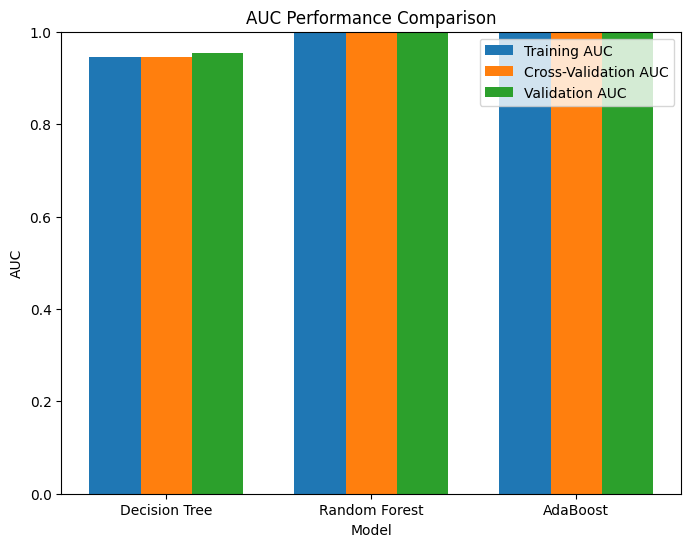

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of model names (keys from the dictionaries)
models_list = list(training_scores.keys())

# Extract the AUC values from each dictionary
train_auc = [training_scores[m]['auc'] for m in models_list]
cv_auc = [np.mean(cv_results[m]['auc']) for m in models_list]
val_auc = [validation_scores[m]['auc'] for m in models_list]

# X-axis positions for each model
x = np.arange(len(models_list))
width = 0.25  # width of each bar

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(x - width, train_auc, width, label='Training AUC')
plt.bar(x, cv_auc, width, label='Cross-Validation AUC')
plt.bar(x + width, val_auc, width, label='Validation AUC')

plt.xlabel("Model")
plt.ylabel("AUC")
plt.title("AUC Performance Comparison")
plt.xticks(x, models_list)
plt.ylim(0, 1)
plt.legend()
plt.show()


# XAI Stuff


Feature Importance (Global)

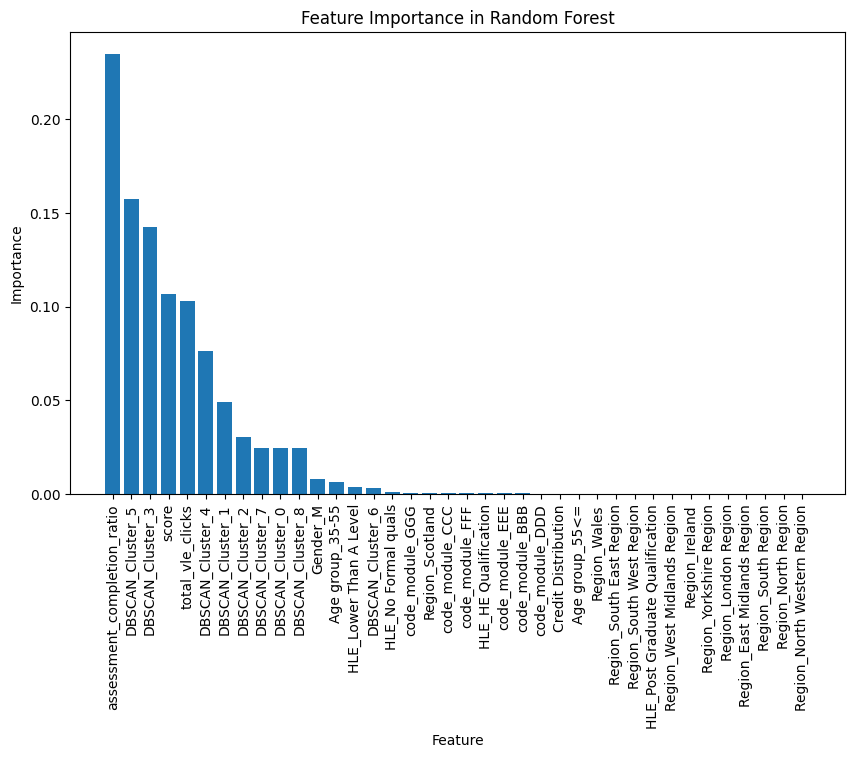

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the Random Forest model
rf_model = models["Random Forest"]  # Get the trained RF model

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


## SHAP for Global & Local Explainability (XAI)

In [ ]:
import shap

# Initialize SHAP explainer for Random Forest
rf_model = models["Random Forest"]  # Get the trained RF model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values[:, :, 0], X_test, feature_names=X_encoded.columns)



ModuleNotFoundError: No module named 'shap'

In [ ]:
# Print the shape of the test data
print("X_test shape:", X_test.shape)

# Print the columns of the encoded features
print("Columns in X_encoded:", list(X_encoded.columns))

# Check the shape of the shap_values
if isinstance(shap_values, list):
    # If it's a list (likely one array per class), print shape for each
    for i, arr in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]:", arr.shape)
else:
    print("Shape of shap_values:", shap_values.shape)
